# UC Berkeley Milling Dataset
> Reproduces the results from the UC Berkeley Milling Dataset.

Here, we will reproduce the results, figures, and tables from the experiment using the UC Berekely Milling Dataset. You can find dataset on the [NASA Prognostics Repository](https://www.nasa.gov/content/prognostics-center-of-excellence-data-set-repository).

A detailed description of the dataset is found in the [PyPHM example notebook](https://github.com/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb) (which you can also [run on Google Colab](https://colab.research.google.com/github/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb)).

First step to reproduce the results is to get the proper environment setup and download the data.

## Table of Contents
* [1. Setup Notebook](#1.-Setup-Notebook) - clone the repo and import require packages
* [2. Explore Data](#2.-Explore-Data) - download the raw data and see how it looks
* [3. Create Train/Val/Test Sets](#3.-Create-Train/Val/Test-Sets) - create the data splits (if you want) and visualize them
* [4. Train Models with a Random Search](#4.-Train-Models-with-a-Random-Search) - train the models
* [5. Summarize Results](#5.-Summarize-Results) - summarize the results of the random search to find the most effective loss functions


# 1. Setup Notebook
**For Google Colab:**
To run the notebook on google colab you must clone the repo an download the data using PyPHM. This can be done by running the following cell.

In [ ]:
# ONLY RUN IF YOU'RE USING GOOGLE COLAB
!git clone https://github.com/tvhahn/tspipe

# move into project folder
%cd tspipe

!pip install pyphm
!pip install -e .

**Import Packages:**
Don't skip this step! Needed for Google Colab and if run locally.

In [1]:
from pyphm.datasets.milling import MillingPrepMethodA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import scipy.io as sio # for reading matlab files

import warnings
warnings.filterwarnings("ignore") # supress all the matplotlib deprecation warnings
%load_ext autoreload
%autoreload 2

In [2]:
# set the project (root folder) and the data folder locations
path_colab = Path.cwd().parent.parent / 'content'

if path_colab.exists():
    proj_dir = Path.cwd() # get projet folder of repository - use if on colab
else:
    proj_dir = Path.cwd().parent # on local machine in ./notebooks folder

print(proj_dir) 

/home/tim/Documents/feat-store


**Download the milling dataset:** We will use the [download_data.py](https://github.com/tvhahn/tspipe/blob/master/src/dataprep/download_data.py) script in the `src.dataprep` module to download the data.

In [3]:
!python {proj_dir}/src/dataprep/download_data.py -p {proj_dir}

2022-10-25 14:10:18,065 - __main__ - INFO - Download the datasets


# 2. Explore Data
We can now explore the milling dataset. For a full breakdown of the dataset, see the [example notebook in PyPHM](https://github.com/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb) (Colab notebook [here](https://colab.research.google.com/github/tvhahn/PyPHM/blob/master/notebooks/milling_example.ipynb)).

We'll recreate the figure showing the six different signals using the `plot_raw_milling_signals` function from [visualize.py](https://github.com/tvhahn/tspipe/blob/master/src/visualization/visualize.py#L1075).

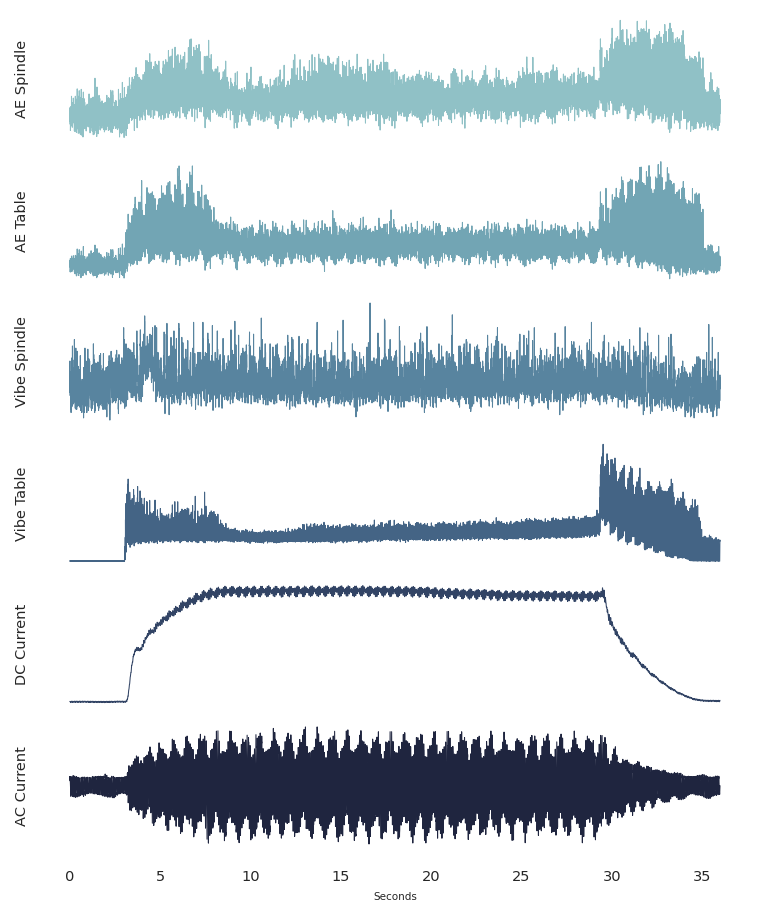

In [4]:
from src.visualization.visualize import plot_raw_milling_signals

raw_data_dir = proj_dir / 'data' / 'raw'

# use PyPHM to load the data
mill = MillingPrepMethodA(root=raw_data_dir, download=False)
data = mill.load_mat()

plot_raw_milling_signals(
    data,
    cut_no=145, # change the cut number to see different cuts
    save_plot=False,
)

# 3. Prep Data
Next, we will break each signal from the dataset into windows. In the paper, we used a window of 1024 and a stride of 64. However, if you are running this on Google Colab, we **need to use a smaller window length to avoid running out of memory**. We will use a window length of 64 and a stride of 64 for this case as a demonstration.

The below script, from [make_dataset_milling.py](https://github.com/tvhahn/tspipe/blob/master/src/dataprep/make_dataset_milling.py), creates the individual windows and saves them as a CSV file in the `data/raw/milling` directory.

In [12]:
# change the window length and stride
WINDOW_LEN = 64
STRIDE = 64
SAVE_DIR_NAME = f'stride{STRIDE}_len{WINDOW_LEN}'

# run the script
!python {proj_dir}/src/dataprep/make_dataset_milling.py \
	-p {proj_dir} \
	--path_data_dir {proj_dir}/data/ \
	--window_len {WINDOW_LEN} \
	--stride {STRIDE} \
	--raw_dir_name {SAVE_DIR_NAME}

2022-10-25 14:19:50,141 - __main__ - INFO - Creating windows of the milling dataset
path_data_dir: /home/tim/Documents/feat-store/data
Shape of final df: (740480, 11)
Saving dataframe as milling.csv.gz ...


In [11]:
# load the milling.csv.gz file with pandas
df = pd.read_csv(proj_dir / 'data' / 'raw' / 'milling' / SAVE_DIR_NAME / 'milling.csv.gz')
df.head()

,cut_id,cut_no,case,time,ae_spindle,ae_table,vib_spindle,vib_table,smcdc,smcac,tool_class
0,0_0,0,1,0.000,0.219727,0.272827,0.733643,2.116699,6.840820,0.124512,0
1,0_0,0,1,0.004,0.246582,0.322266,0.778809,2.277832,6.660156,-0.561523,0
2,0_0,0,1,0.008,0.294189,0.283813,0.758057,2.343750,6.508789,-2.099609,0
3,0_0,0,1,0.012,0.323486,0.260010,0.726318,2.448730,6.542969,-2.731934,0
4,0_0,0,1,0.016,0.290527,0.253296,0.653076,2.546387,6.621094,-3.505859,0


The dataframe (`df`), above, can now be used with the [tsfresh](https://github.com/blue-yonder/tsfresh) feature engineering package. We'll use that next.